# 描述

设计基于LeNet5的卷积神经网络对MINSI数据集进行训练和测试。

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# 将图和数据内联在notebook里
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 图像显示函数
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # 图像维度重塑成(batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 
    
%load_ext autoreload
%autoreload 2

## Dataset

使用MNIST数据集，它包含6万张训练图和1万张测试图。每张图片都包含一幅以白色数字为中心的图像，背景为黑色(0到9)。这

为了简化这里的代码，我们将使用PyTorch MNIST包装器，它下载并加载MNIST数据集

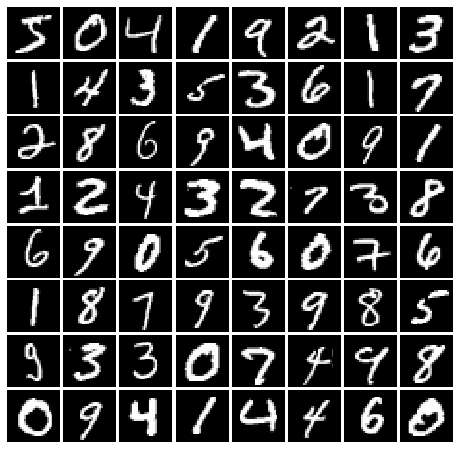

In [2]:
# 继承Pytorch采样类，编写自定义类
# start是数据开始位置_
# num_samples是抽样个数
class ChunkSampler(sampler.Sampler):
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples
# 定义数据长度参数
NUM_TRAIN = 55000
NUM_VAL = 5000
# 每批次数据长度
BATCH_SIZE=64
# 训练数据集
mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=BATCH_SIZE,
                          sampler=ChunkSampler(NUM_TRAIN, 0))
# 交叉验证集
mnist_val = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=BATCH_SIZE,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(BATCH_SIZE, 784).numpy().squeeze()
show_images(imgs) # 展示图例

## CPU/GPU

使用GPU或者CPU进行训练和测试。

In [3]:
USE_GPU = True # 默认CPU

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor     
# 打印设备使用情况   
print('using device:', device)

using device: cuda


In [4]:
# 编写图像拉伸展开类
# nn.Linear()的输入输出都是一维的，所以要把多维度的tensor展平成一维
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() 
        return x.view(N, -1)

In [5]:
# 定义基于LeNet的变种网络结构
class VarLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential( # 输入(1*28*28)
            nn.Conv2d(1, 6, 5, 1, 2), # padding=2保证输入输出尺寸相同
            nn.ReLU(), # (6*28*28)
            nn.MaxPool2d(2, 2), # (6*14*14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(), # (16*10*10)
            nn.MaxPool2d(2, 2)  # (16*5*5)
        )
        self.flatten=nn.Flatten() 
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)      
    # 定义前向传播过程，输入为x
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [6]:
EPOCH = 8   #遍历数据集次数
# 定义损失函数loss function
convnet = VarLeNet().to(device)
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
# 使用Adma
optimizer = optim.Adam(convnet.parameters(), lr=1e-3, betas=(0.9,0.999))

In [7]:
# 损失缓存
loss_history=[]
# 精度缓存
accuracy_history=[]

In [8]:
# 定义训练函数
def train():
    if __name__ == "__main__":
        for epoch in range(EPOCH):
            sum_loss=0.0
            # 数据读取
            for i, data in enumerate(loader_train):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                # 梯度清零
                optimizer.zero_grad()
                # 前向传播
                outputs = convnet(inputs)
                loss = criterion(outputs, labels)
                # 后向传播
                loss.backward()
                # 梯度优化
                optimizer.step()
                # 将tensor类型转成数据类型进行损失累加
                sum_loss += loss.item()
                # 每训练100个batch打印一次平均loss
                if i % 100 == 99:
                    print('[%d, %d] loss: %.03f'% (epoch + 1, i + 1, sum_loss / 100))
                    # 缓存损失值
                    loss_history.append(sum_loss/100)
                    sum_loss = 0.0           
            # 跑完一次epoch测试一下准确率
            with torch.no_grad():
                num_correct = 0.0
                num_total = 0.0
                for i, data in enumerate(loader_val):
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = convnet(images)
                    # 取得分最高的那个类
                    _, predicted = torch.max(outputs.data, 1)
                    num_total += labels.size(0)
                    num_correct += (predicted == labels).sum()
                accuracy_history.append( (num_correct.item() / num_total))
                print('第%d个epoch的识别准确率为：%d%%' % (epoch + 1, (100 * num_correct / num_total)))
        # 画出损失图像
        plt.subplot(2, 1, 1)
        plt.title('Training loss')
        plt.plot(loss_history, 'o')
        plt.xlabel('Iteration(x100)')
        # 画出精度图像
        plt.subplot(2, 1, 2)
        plt.title('Accuracy')
        plt.plot(accuracy_history, '-o')
        plt.xlabel('Epoch')
        plt.gcf().set_size_inches(15, 12)
        plt.show()
        return

[1, 100] loss: 1.236
[1, 200] loss: 0.377
[1, 300] loss: 0.259
[1, 400] loss: 0.184
[1, 500] loss: 0.183
[1, 600] loss: 0.145
[1, 700] loss: 0.143
[1, 800] loss: 0.137
第1个epoch的识别准确率为：97%
[2, 100] loss: 0.097
[2, 200] loss: 0.103
[2, 300] loss: 0.093
[2, 400] loss: 0.071
[2, 500] loss: 0.092
[2, 600] loss: 0.078
[2, 700] loss: 0.083
[2, 800] loss: 0.082
第2个epoch的识别准确率为：98%
[3, 100] loss: 0.066
[3, 200] loss: 0.069
[3, 300] loss: 0.062
[3, 400] loss: 0.045
[3, 500] loss: 0.062
[3, 600] loss: 0.055
[3, 700] loss: 0.063
[3, 800] loss: 0.058
第3个epoch的识别准确率为：98%
[4, 100] loss: 0.049
[4, 200] loss: 0.051
[4, 300] loss: 0.047
[4, 400] loss: 0.035
[4, 500] loss: 0.047
[4, 600] loss: 0.044
[4, 700] loss: 0.049
[4, 800] loss: 0.043
第4个epoch的识别准确率为：98%
[5, 100] loss: 0.038
[5, 200] loss: 0.041
[5, 300] loss: 0.033
[5, 400] loss: 0.028
[5, 500] loss: 0.037
[5, 600] loss: 0.038
[5, 700] loss: 0.039
[5, 800] loss: 0.035
第5个epoch的识别准确率为：98%
[6, 100] loss: 0.031
[6, 200] loss: 0.030
[6, 300] loss: 0.0

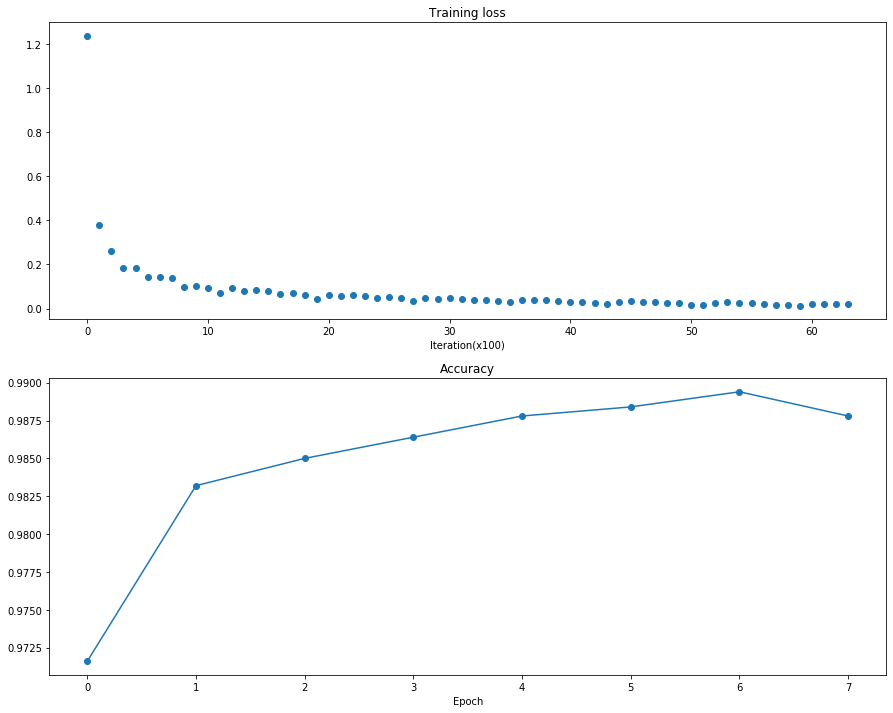

In [9]:
# 调用函数进行训练
train()